In [2]:
from google.colab import drive
# from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf



In [6]:
# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels


In [7]:
# Rescale and reshape the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN input (Ensure correct shape for ResNet50)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [8]:
# Load ResNet50 model pre-trained on ImageNet (exclude the top layers)
from tensorflow.keras.applications import ResNet50
# Existing line should now work:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))





# Freeze the layers of ResNet50 base model
for layer in resnet50_base.layers:
    layer.trainable = False


In [9]:
# Build the model using Sequential with additional regularization and dropout
from tensorflow.keras.regularizers import l2
model = Sequential([
    resnet50_base,
    GlobalAveragePooling2D(),  # Global pooling to reduce spatial dimensions
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization added
    Dropout(0.5),  # Dropout to avoid overfitting
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # L2 regularization on the output layer
])


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Define Data Generator for Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(X_train)


In [12]:
# Define Learning Rate Reduction and Early Stopping for better convergence
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on validation data
        y_pred = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        y_true = self.validation_data[1]

        # Print classification report metrics: precision, recall, f1-score
        report = classification_report(y_true, y_pred, output_dict=True)
        print(f"Epoch {epoch + 1} Classification Report:")
        print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1-Score: {report['1']['f1-score']:.4f}")

# Create an instance of the MetricsCallback and set validation data for it
metrics_callback = MetricsCallback()
metrics_callback.validation_data = (X_test, y_test)

In [13]:
# Train the model
batch_size = 32
epochs = 30  # Increased epochs for better model training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[lr_reduction, early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 193s 736ms/step - accuracy: 0.5612 - loss: 0.7779 - val_accuracy: 0.6575 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 196s 712ms/step - accuracy: 0.6394 - loss: 0.6621 - val_accuracy: 0.6800 - val_loss: 0.6331 - learning_rate: 0.0010
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 192s 671ms/step - accuracy: 0.6412 - loss: 0.6530 - val_accuracy: 0.6775 - val_loss: 0.6368 - learning_rate: 0.0010
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 171s 678ms/step - accuracy: 0.6655 - loss: 0.6292 - val_accuracy: 0.6276 - val_loss: 0.6353 - learning_rate: 0.0010
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 185s 737ms/step - accuracy: 0.6731 - loss: 0.6249 - val_accuracy: 0.7009 - val_loss: 0.6042 - learning_rate: 0.0010
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 195s 710ms/step - accuracy: 0.6831 - loss: 0.6208 - val_accuracy: 0.6695 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 181s 719ms/step - accuracy: 0.6835 

In [14]:
#Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 494ms/step - accuracy: 0.7031 - loss: 0.5881
Test Accuracy: 71.89%


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,374,917 (92.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 524,804 (2.00 MB)

In [20]:
model.save("FINAL_RESNET_model.h5")
model.save('FINAL_RESNET_model.keras')

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Predictions
# y_train_pred = model.predict(X_train)
# y_train_pred_classes = np.argmax(y_train_pred, axis=1)
# y_train_true_classes = np.argmax(y_train, axis=1)

# y_test_pred = model.predict(X_test)
# y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# y_test_true_classes = np.argmax(y_test, axis=1)

y_train_pred = model.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_train_true_classes = np.argmax(y_train, axis=1) # This line is removed
y_train_true_classes = y_train # y_train already contains the true class labels

y_test_pred = model.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_test_true_classes = np.argmax(y_test, axis=1) # This line is removed
y_test_true_classes = y_test # y_test already contains the true class labels

# Metrics
train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)

test_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step
Training Metrics:
Accuracy: 0.7329, Precision: 0.7459, Recall: 0.7329, F1-Score: 0.7298

Testing Metrics:
Accuracy: 0.7189, Precision: 0.7308, Recall: 0.7189, F1-Score: 0.7160


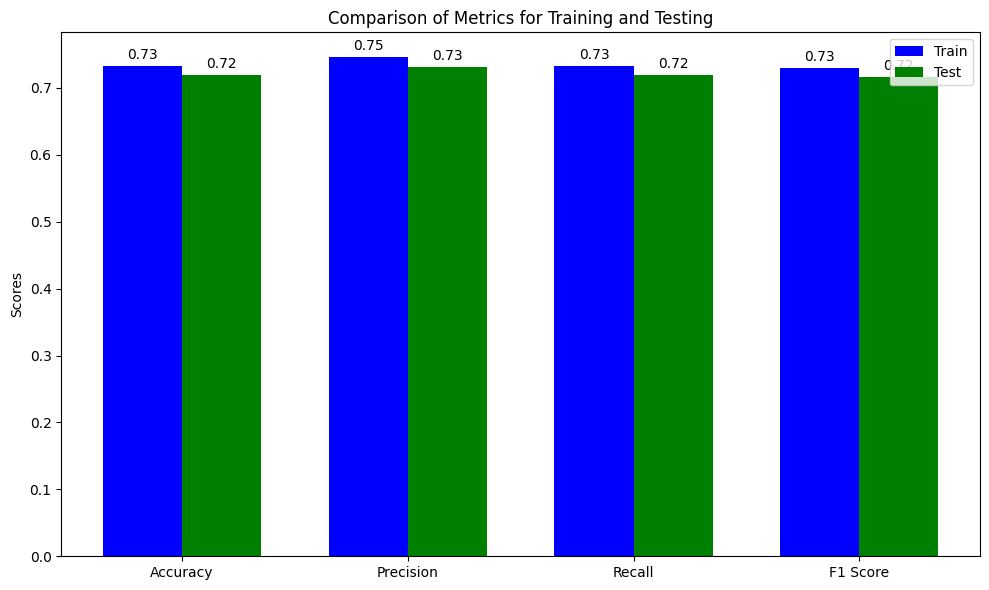

In [22]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_values = [train_accuracy, train_precision, train_recall, train_f1]
test_values = [test_accuracy, test_precision, test_recall, test_f1]

# Set up the bar plot
width = 0.35  # Width of the bars
x = np.arange(len(metrics))  # The label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for training and testing metrics
rects1 = ax.bar(x - width/2, train_values, width, label='Train', color='blue')
rects2 = ax.bar(x + width/2, test_values, width, label='Test', color='green')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add the labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each bar
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()